# Bird Call Classification
# Overview

This project is an offshoot from a kaggle competetition to identify birdcalls in soundscape recordings.  This competition can be broken into two challenges. first is to identify sounds that are birdcalls in the soundscapes.  The second is to correctly identify the species that produced this call.  here in this notebook, I go after the second challenge.  The strategies and lessons learned here will hopefully help the soundscape identification challenge.

https://www.kaggle.com/c/birdclef-2021/overview


# Goal

Classify the species of any given bird call recording, from a subset of the full bird call database.

The overall database contains 62874 calls with 397 species, totalling over 39 Gb.  Before venturing out and dedicating computing power and time to such a large task, effective strategies that have a strong chance of success should be developed.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import tensorflow as tf

In [2]:
metadata = pd.read_csv('../data/train_metadata.csv')
soundscape = pd.read_csv('../data/train_soundscape_labels.csv')

In [3]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62874 entries, 0 to 62873
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     62874 non-null  object 
 1   secondary_labels  62874 non-null  object 
 2   type              62874 non-null  object 
 3   latitude          62874 non-null  float64
 4   longitude         62874 non-null  float64
 5   scientific_name   62874 non-null  object 
 6   common_name       62874 non-null  object 
 7   author            62874 non-null  object 
 8   date              62874 non-null  object 
 9   filename          62874 non-null  object 
 10  license           62874 non-null  object 
 11  rating            62874 non-null  float64
 12  time              62874 non-null  object 
 13  url               62874 non-null  object 
dtypes: float64(3), object(11)
memory usage: 6.7+ MB


In [4]:
metadata.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981


### Checking name uniqueness
All three fields for names, common name, primary label and scientific name align.

In [5]:
print(f'unique common names: {metadata["common_name"].nunique()}')
print(f'unique primary labels: {metadata["primary_label"].nunique()}')
print(f'unique scientific name: {metadata["scientific_name"].nunique()}')
print(f'unique combinations: {(metadata["primary_label"] + metadata["common_name"] + metadata["scientific_name"]).nunique()}')

unique common names: 397
unique primary labels: 397
unique scientific name: 397
unique combinations: 397


### Checking type values
Thre's a large variety of types within the data.  stored values are lists stored as a string.  To utilize this field, list extraction and analysis would need to be done.  also, the type is not consistent.  Where some files may have female or male in the type, most don't have this.  Many files have no information stored in type.

In [6]:
print(f'unique types: {metadata["type"].nunique()}')
print('examples:')
for num in range(0,10):
    print(metadata['type'].unique()[num])

unique types: 3090
examples:
['begging call', 'call', 'juvenile']
['call']
['call', 'song']
['song']
['song', 'twitter accompanied by wing fluttering or short flights']
['dawn song']
['call', 'female']
['call', 'female', 'sitting on  nest']
['call', 'fall migration "whit!"']
['male', 'song', 'twittering']


### visualizing geographic spread of recordings
created a scatter plot of latitude and longitude, for a rough estimation.
The recordings cover are throughout the planet, but are heavily concentrated in Europe and the Americas.

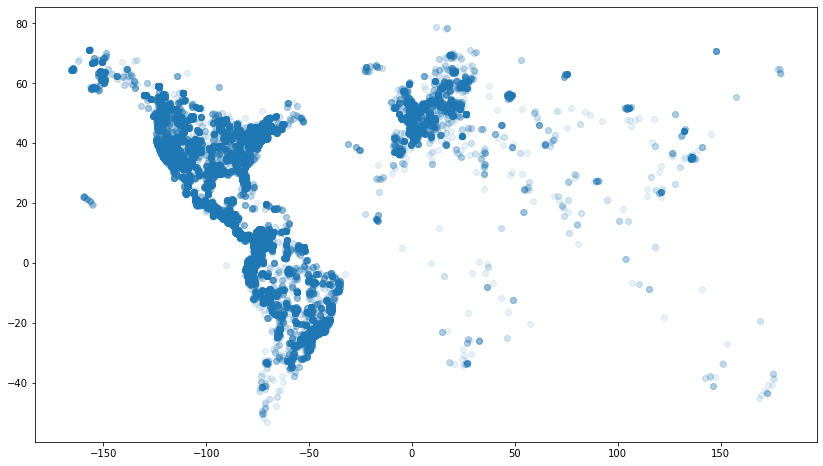

In [7]:
plt.figure(figsize = (14,8))
plt.scatter(metadata['longitude'],metadata['latitude'], alpha = 0.1)

## Narrowing the data
### Narrowing to the west coast of the US.
this choice is arbitrary.  but that's okay for the goal we have.  data is narrowed to the west coast by creating a box using the latitude and longitude.
- latitude: 35 to 52
- longitude: -115 to -125

In [8]:
pnw = metadata.loc[metadata['latitude'] < 52 ]
pnw = pnw.loc[metadata['latitude'] > 35 ]
pnw = pnw.loc[metadata['longitude'] > -125 ]
pnw = pnw.loc[metadata['longitude'] < -115 ]

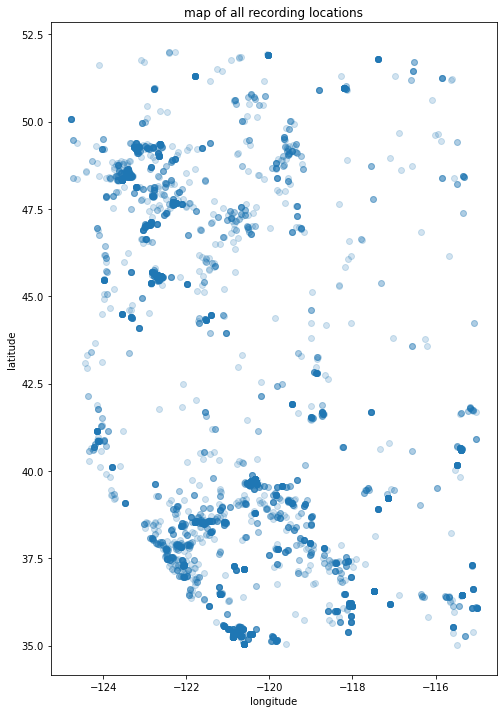

In [9]:
plt.figure(figsize = (8,12))
plt.scatter(pnw['longitude'],pnw['latitude'], alpha = 0.2)
plt.title('map of all recording locations')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

### number of species and recordings in banded area
there are 188 unique species and 5128 recordings.  this is an average of 27 recordings per species, which would be incredibly difficult to fit on.  188 is also extremely large for a multi-classification neural network, and defeat the quick iteration we're looking for.

In [10]:
print(f'number of unique species on west coast: {pnw["primary_label"].nunique()}')
print(f'number of recordings on west coast: {pnw.shape[0]}')
pnw['common_name'].value_counts()[:10]

number of unique species on west coast: 188
number of recordings on west coast: 5128


Spotted Towhee             234
Bewick's Wren              158
White-crowned Sparrow      119
Black-headed Grosbeak      118
Swainson's Thrush          113
Song Sparrow               108
Marsh Wren                  88
MacGillivray's Warbler      87
White-breasted Nuthatch     85
Steller's Jay               84
Name: common_name, dtype: int64

### choosing top 5 species for modeling
The species with the most recordings are chosen.  the number of recordings for these range from 234 to 113, which is on the low end but may still be okay.

In [11]:
top_five_labels = list(pnw['common_name'].value_counts()[:5].index)
top_five_labels

['Spotted Towhee',
 "Bewick's Wren",
 'White-crowned Sparrow',
 'Black-headed Grosbeak',
 "Swainson's Thrush"]

In [12]:
pnw_top = pnw.loc[pnw['common_name'].isin(top_five_labels)]

### Checking geography of top 5
The distribution of the top 5 maps is similar to the total recordings on the west coast.

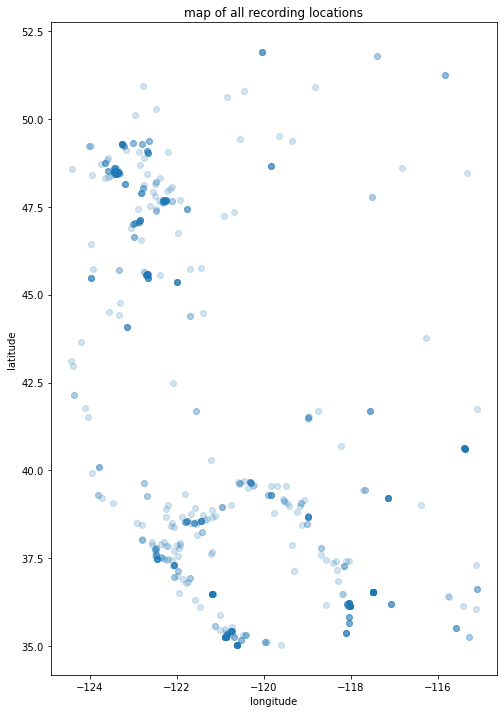

In [13]:
plt.figure(figsize = (8,12))
plt.scatter(pnw_top['longitude'],pnw_top['latitude'], alpha = 0.2)
plt.title('map of all recording locations')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

### lets look at the full range of the top 5 species

In [14]:
metadata_top = metadata.loc[metadata['common_name'].isin(top_five_labels)]

In [15]:
metadata_top.shape

(1945, 14)

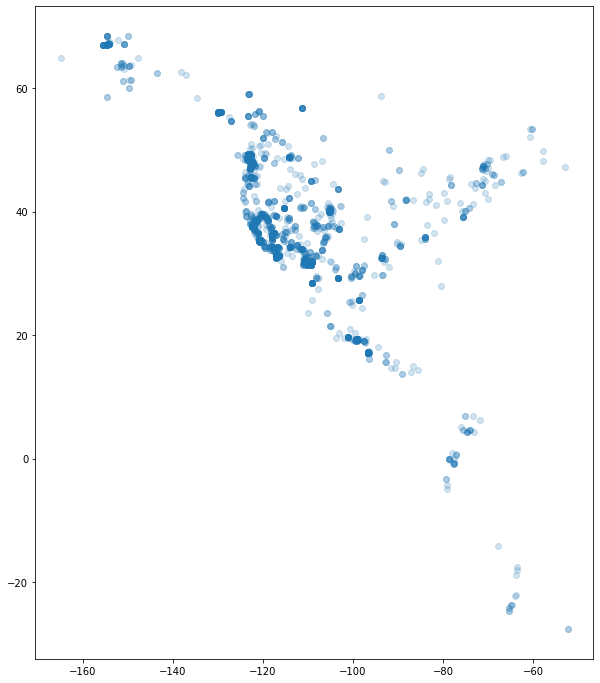

In [16]:
plt.figure(figsize = (10,12))
plt.scatter(metadata_top['longitude'],metadata_top['latitude'], alpha = 0.2)

## Importing recordings
librosa is the package used to load and manipulate sound recordings.

NOTE: All sound files should be located at this location in relation to to this notebook:

'../../sounds/train_short_audio/'

Just as in the kaggle folder structure, sound files within train_short_audio should be in subfolders labeled by the primary_label for the recording.

Warning, this input will take a while

In [17]:
# reset index to run from 0 to X by 1 to keep it clean
pnw_top.reset_index(inplace = True, drop = True)
# set data storage list
sound_data = []
# extract as a floating point time series, using the default sample rate of 22050
for num in range(0,pnw_top.shape[0]):
    dir = f'../../sounds/train_short_audio/{pnw_top.at[1,"primary_label"]}/{pnw_top.at[1,"filename"]}'
    sound_data.append(librosa.load('../../sounds/train_short_audio/bewwre/XC109604.ogg'))

## Create spectrograms for modelling
The spectrogram is what will be used as the input to the neural network.  Then neural network strategies that work for images can be used.

In [18]:
# set spectrogram storage list
spectrograms = []
# for each value 
for sound_clip in sound_data:
    spectrograms.append(librosa.feature.melspectrogram(sound_clip[0],
                                                      sr=sound_clip[1]))

In [19]:
log_spectrograms = []
for spectrogram in spectrograms:
    log_spectrograms.append( librosa.power_to_db(spectrogram, ref=np.max) )

In [20]:
length_calc = []
for sound_clip in sound_data:
    temp = {'num_points': len(sound_clip[0]),
           'sample_rate': sound_clip[1],
           'time_len': (len(sound_clip[0])/sound_clip[1])}
    length_calc.append(temp)

length_calc = pd.DataFrame(length_calc, index = list(range(0,len(length_calc))))
length_calc.describe()

,num_points,sample_rate,time_len
count,742.0,742.0,7.420000e+02
mean,1111078.0,22050.0,5.038902e+01
std,0.0,0.0,6.754709e-13
min,1111078.0,22050.0,5.038902e+01
25%,1111078.0,22050.0,5.038902e+01
50%,1111078.0,22050.0,5.038902e+01
75%,1111078.0,22050.0,5.038902e+01
max,1111078.0,22050.0,5.038902e+01


In [21]:
# helper function 
def plot_sound_clip(data):

    fig = plt.figure(figsize=(8, 4))
    x = range(len(data))
    y = data
    plt.plot(x, y)
    plt.grid()

def plot_spectrogram(spectrogram):
    ax = plt.figure(figsize = (10,5)).add_subplot()
    librosa.display.specshow(spectrogram, x_axis='time', y_axis='off', ax = ax) #y_axis = 'mel'
    plt.show()

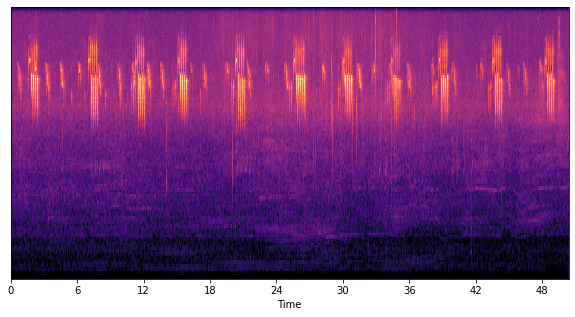

In [22]:
plot_spectrogram(log_spectrograms[3])

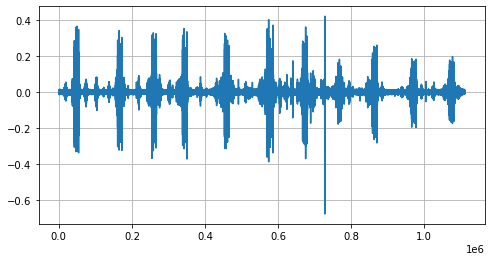

In [23]:
plot_sound_clip(sound_data[0][0])

### Cutting down the spectrogram 
After having visualized a sprectrograms from different species, it's likely the spectrograph can be narrowed in both length, and frequency range with only a loss of noise.  This will help free up memory so a more comprehensive neural net can be built and remove noise.

In [24]:
# set spectrogram storage list
spectrograms = []
# for each value 
for sound_clip in sound_data:
    spectrograms.append(librosa.feature.melspectrogram(sound_clip[0][:250_000],
                                                      sr=sound_clip[1])[30:-3])

In [25]:
log_spectrograms = []
for spectrogram in spectrograms:
    log_spectrograms.append( librosa.power_to_db(spectrogram, ref=np.max) )

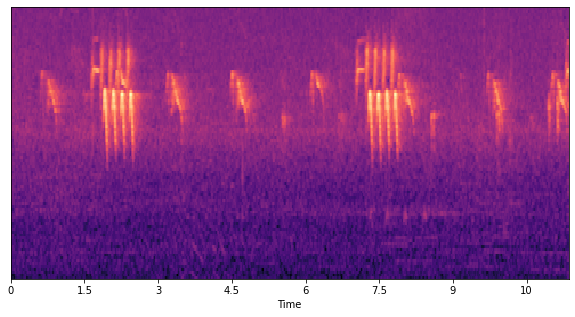

In [26]:
plot_spectrogram(log_spectrograms[3])

## Prep data for model

In [27]:
y = pnw_top['common_name']
y = pd.get_dummies(y)
y.head()

,Bewick's Wren,Black-headed Grosbeak,Spotted Towhee,Swainson's Thrush,White-crowned Sparrow
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [28]:
len(log_spectrograms), log_spectrograms[0].shape

(742, (95, 489))

In [29]:
X = np.array(log_spectrograms).reshape(742, 95, 489, 1)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

## Build and fit Model
model structure is built of:
- convolutional layer(s)
- pooling layer(s)
- Dense layers
- early stopping

In [31]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [54]:
cnn = Sequential()
cnn.add(Conv2D(filters = 128,       #number of filters to use
              kernel_size = (3, 3),   #dimensions of the filters
              activation = 'relu',    #activation function
              input_shape = (95, 489,1)))  #shape of image
cnn.add(MaxPooling2D(pool_size = (2, 2))) 
cnn.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))  
cnn.add(Flatten())
cnn.add(Dense(32, activation = 'relu'))
cnn.add(Dense(32, activation = 'relu'))
cnn.add(Dense(32, activation = 'relu'))
cnn.add(Dense(32, activation = 'relu'))
cnn.add(Dense(32, activation = 'relu'))
cnn.add(Dense(32, activation = 'relu'))
cnn.add(Dense(16, activation = 'relu'))
cnn.add(Dense(16, activation = 'relu'))
cnn.add(Dense(5, activation = 'softmax'))
cnn.compile(loss = 'binary_crossentropy',
           optimizer = 'adam',
           metrics = ['accuracy'])

In [55]:
history_1 = cnn.fit(X_train, y_train, validation_data = (X_test, y_test),
                 epochs = 20,
                 verbose = 1, 
                 batch_size = 16,
                 callbacks=[early_stop]                 
    )

Epoch 1/20
33/33 [==============================] - 5s 129ms/step - loss: 0.8205 - accuracy: 0.2775 - val_loss: 0.5329 - val_accuracy: 0.3004
Epoch 2/20
33/33 [==============================] - 3s 78ms/step - loss: 0.5204 - accuracy: 0.3218 - val_loss: 0.4979 - val_accuracy: 0.3004
Epoch 3/20
33/33 [==============================] - 4s 116ms/step - loss: 0.4946 - accuracy: 0.3218 - val_loss: 0.5226 - val_accuracy: 0.3004
Epoch 4/20
33/33 [==============================] - 3s 79ms/step - loss: 0.4990 - accuracy: 0.2929 - val_loss: 0.5183 - val_accuracy: 0.3004
Epoch 5/20
33/33 [==============================] - 3s 78ms/step - loss: 0.4954 - accuracy: 0.3218 - val_loss: 0.4928 - val_accuracy: 0.3004
Epoch 6/20
33/33 [==============================] - 4s 117ms/step - loss: 0.4949 - accuracy: 0.3218 - val_loss: 0.4913 - val_accuracy: 0.3004
Epoch 7/20
33/33 [==============================] - 3s 78ms/step - loss: 0.4922 - accuracy: 0.3218 - val_loss: 0.4927 - val_accuracy: 0.3004
Epoch 8/20

#### history_1
initial run
- convo 64, (10,10)
- pooling (2,2)
- convo 64, (10,10)
- pooling (2,2)
- convo 64, (10,10)
- pooling (2,2)
- dense 64
- dense 64
- dense 64
- dense 5

#### history_2
- convo 128, (3,3)
- pooling (2,2)
- convo 128, (3,3)
- pooling (2,2)
- convo 64, (10,10)
- pooling (2,2)
- dense 64
- dense 32
- dense 32
- dense 5

#### history_3
- convo 128, (3,3)
- pooling (2,2)
- convo 32, (8,8)
- pooling (2,2)
- convo 32, (8,8)
- pooling (2,2)
- dense 64
- dense 64
- dense 64
- dense 5


#### history_4
- convo 128, (3,3)
- pooling (2,2)
- convo 128, (3,3)
- pooling (2,2)
- dense 64
- dense 64
- dense 64
- dense 5

#### history_4
- convo 128, (3,3)
- pooling (2,2)
- convo 64, (3,3)
- pooling (2,2)
- dense 32
- dense 32
- dense 32
- dense 32
- dense 32
- dense 32
- dense 16
- dense 16
- dense 5

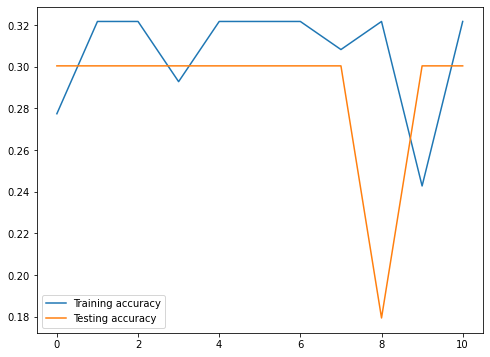

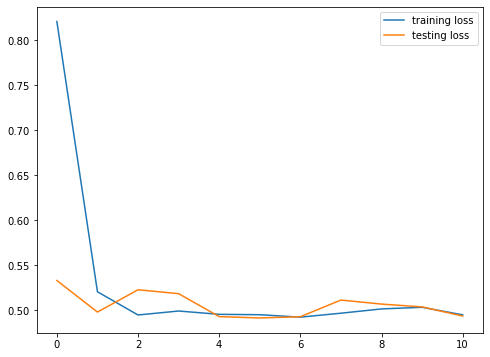

In [56]:
train_loss = history_1.history['accuracy']
test_loss = history_1.history['val_accuracy']
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training accuracy')
plt.plot(test_loss, label='Testing accuracy')
plt.legend();
plt.show()

train_loss = history_1.history['loss']
test_loss = history_1.history['val_loss']
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='training loss')
plt.plot(test_loss, label='testing loss')
plt.legend();
plt.show()

# Results and Conclusion

running a convolutional neural network on the spectrogram of the bird call, even when cut down in length and frequency range, did not yield any kind of ability to predict bird species.  All the above models hit early stopping before epoch 20 (early stopping at 5 with no decreas in loss).  training accuracy always maxes out at 0.32, and testing accuracy holds at 0.30.



# Future steps

In continuing with the spectrogram/image neural net strategy:
- additional work needs to be done on preprocessing to create more clarity for the neural net.  Adding noise to the spectrograph my focus the model on the actual signal.
- Implementing prebuilt models that have worked well for other image classification tasks may have better results.  to use them, cloud services may be needed for access to enough gpu memory
- identifying if there's too much variation within species based on type of call would help as well.  then classes could be built to be a combination of species and type of call.

There may also be additional signals that can be found by characterizing the sound outside of just the spectrogram.  Further signal analysis needs to be done to find differentiating features.